In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
#argumentos da rede neural
imageSize = 256 
batchSize = 32
channels = 3
epochs = 50

<h2>Importação de dados</h2>

In [4]:
#criando dataset de imagens
dataset = tf.keras.preprocessing.image_dataset_from_directory( 
    "dataset", #nome do diretório
    shuffle=True, #embraralhando o dataset
    image_size = (imageSize, imageSize),#altera a dimensão da imagem para  256x256 pixels
    batch_size = batchSize #número de imagens que serão processadas em conjunto em cada iteração durante o treinamento ou inferência do modelo.
)

#p/ um lote de 100 imagens, se eu tiver um batch size de 32, eu tenho 100/32 == 3.1 batchs de imagem

Found 442 files belonging to 2 classes.


In [5]:
classNames = dataset.class_names #importando os nomes das classes e guardando elas em um vetor chamado classnames
classNames #

['doente', 'saudavel']

In [6]:
len(dataset) #printando a quantidade de batches

14

In [7]:
for image_batch, labels_batch in dataset:
    print(image_batch.shape) # imprime uma estrutura de dados multidimensional (um tensor de imagens) contendo
    #32 imagens, 256 pixels de largura, 256 pixels de altura e 3 canais de cor (Red, Green e Blue)
    print(labels_batch.numpy()) #printa o batch

(32, 256, 256, 3)
[0 1 1 0 0 0 1 1 0 0 1 0 0 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1]
(32, 256, 256, 3)
[1 1 1 0 1 0 0 1 0 0 0 1 0 1 1 1 1 0 1 0 0 0 1 1 1 0 0 0 1 1 1 0]
(32, 256, 256, 3)
[0 0 0 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 0 1 1 1]
(32, 256, 256, 3)
[0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 0 0]
(32, 256, 256, 3)
[0 1 1 1 0 0 0 1 1 1 1 0 0 0 1 0 1 1 1 1 0 0 1 0 1 1 1 1 0 1 0 1]
(32, 256, 256, 3)
[1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0]
(32, 256, 256, 3)
[0 1 1 0 0 1 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 1 1 0 1 0]
(32, 256, 256, 3)
[0 1 1 1 1 0 1 0 0 1 1 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0]
(32, 256, 256, 3)
[1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 0 1]
(32, 256, 256, 3)
[0 0 1 0 0 1 0 1 1 1 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0]
(32, 256, 256, 3)
[1 0 1 0 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 0 1 1 1 1 0 1]
(32, 256, 256, 3)
[0 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1

<h3>Visualização de imagens no dataset</h3>

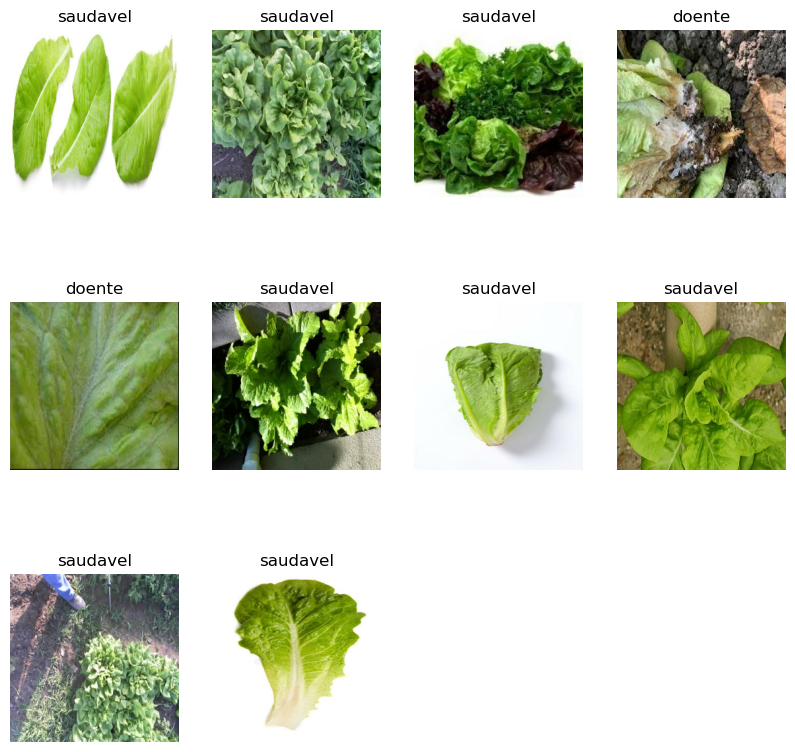

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(3, 4, i + 1) #cria um layout de exibição de 3 linhas por 4 colunas, onde i + 1 é a posição 1 até a posoção 12
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classNames[labels_batch[i]])
        plt.axis("off")

<h2>Criação do dataset</h2>

In [9]:
def getDatasetPartitionsTf(ds, trainSplit = 0.8, validationSplit = 0.1, testSplit = 0.1, shuffle = True, shuffleSize = 10000):
    #obtendo tamanho do dataset
    dsSize = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffleSize, seed=12)
    #obtendo tamanho do dataset de treino
    trainSize = int(trainSplit * dsSize)
    
    #obtendo tamanho do dataset de validação
    validationSize = int(validationSplit* dsSize)

    #carregando o dataset de treino com o respectivo tamanho
    trainDs = ds.take(trainSize)

    #carregando o dataset de validação com o respectivo tamanho
    validationDs = ds.skip(trainSize).take(validationSize)

    #carregando o dataset de teste com o respectivo tamanho
    testDs = ds.skip(trainSize).take(validationSize)
    
    return trainDs, validationDs, testDs

In [10]:
trainDs, validationDs, testDs = getDatasetPartitionsTf(dataset)

In [11]:
len(trainDs)

11

In [12]:
len(validationDs)

1

In [13]:
len(testDs)

1

<h3>Pré-processamento</h3>

In [14]:
resizeAndRescale = tf.keras.Sequential([
#preprocessamento para alterar o tamanho da imagem para 256x256, caso a imagem não tenha essa dimensão
    layers.experimental.preprocessing.Resizing(imageSize,imageSize),
#preprocessamento para alterar a escala entre um valor de 0 a 1 (faixa de valores aceita pelo numpy é de 0 a 255)
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

<h3>Data augmentation</h3>

In [15]:
def edge_enhance(x):
    kernel = tf.constant([
        [[[-1]], [[-1]], [[-1]]],
        [[[-1]], [[ 9]], [[-1]]],
        [[[-1]], [[-1]], [[-1]]]
    ], dtype=tf.float32)
    kernel = tf.repeat(kernel, x.shape[-1], axis=2)  # Repete o canal
    return tf.nn.depthwise_conv2d(x, kernel, strides=[1,1,1,1], padding='SAME')

layers.Lambda(edge_enhance)


In [16]:
def salient_edges(x):
    gray = tf.image.rgb_to_grayscale(x)
    sobel = tf.image.sobel_edges(gray)
    mag = tf.sqrt(tf.reduce_sum(tf.square(sobel), axis=-1))
    mag = tf.clip_by_value(mag, 0, 255)
    return tf.image.grayscale_to_rgb(mag)


In [17]:
"""dataAugmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])
"""


dataAugmentation = tf.keras.Sequential([
    # Geometric augmentations
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    #layers.RandomCrop(height=target_height, width=target_width),

    # Color augmentations
    layers.RandomContrast(0.2),
    layers.Lambda(lambda x: tf.image.random_brightness(x, max_delta=0.2)),
    layers.Lambda(lambda x: tf.image.random_saturation(x, lower=0.8, upper=1.2)),
    #layers.Lambda(lambda x: tf.image.rgb_to_grayscale(x)),  # de-colorização

    # Texture manipulation
    layers.Lambda(lambda x: tf.nn.avg_pool2d(x, ksize=3, strides=1, padding='SAME')),  # de-texturização

    # Edge enhancement
    layers.Lambda(edge_enhance),

    # Salient edge map (can be an alternative path or extra augmentation)
    #layers.Lambda(salient_edges),
])


<h3>Treinamento</h3>

In [18]:
inputShape = (batchSize, imageSize, imageSize, channels)
INPUT_SHAPE = (imageSize, imageSize, channels)
nClasses = 1
model = models.Sequential([
    resizeAndRescale,
    dataAugmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = INPUT_SHAPE),
    layers.MaxPooling2D((2,2)),
    # layers.Dropout(0.25),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    # layers.Dropout(0.25),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    # layers.Dropout(0.25),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    # layers.Dropout(0.25),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    # layers.Dropout(0.25),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    # layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(nClasses, activation='sigmoid')
])

model.build(input_shape = inputShape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

<h3>Treinamento e compilação </h3>

<h4>Compilação</h4>

In [20]:
model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [21]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  # Monitora a perda na validação
    patience=5,  # Para se não melhorar por 5 épocas
    restore_best_weights=True  # Usa os melhores pesos ao final
)

<h4>Treinamento</h4>

In [22]:
history = model.fit(
    trainDs,
    epochs=epochs,
    batch_size=batchSize,
    verbose=1,
    validation_data=validationDs
)

Epoch 1/50
11/11 [==============================] - 25s 996ms/step - loss: 0.7527 - accuracy: 0.4827 - val_loss: 0.6915 - val_accuracy: 0.5938
Epoch 2/50
11/11 [==============================] - 12s 1s/step - loss: 0.6884 - accuracy: 0.5549 - val_loss: 0.6781 - val_accuracy: 0.6875
Epoch 3/50
11/11 [==============================] - 12s 1s/step - loss: 0.6430 - accuracy: 0.6420 - val_loss: 0.6446 - val_accuracy: 0.6154
Epoch 4/50
11/11 [==============================] - 12s 1s/step - loss: 0.7081 - accuracy: 0.5636 - val_loss: 0.6750 - val_accuracy: 0.7188
Epoch 5/50
11/11 [==============================] - 12s 1s/step - loss: 0.6664 - accuracy: 0.7081 - val_loss: 0.5599 - val_accuracy: 0.7812
Epoch 6/50
11/11 [==============================] - 12s 1s/step - loss: 0.6155 - accuracy: 0.6590 - val_loss: 0.5763 - val_accuracy: 0.8125
Epoch 7/50
11/11 [==============================] - 12s 1s/step - loss: 0.5945 - accuracy: 0.7052 - val_loss: 0.6210 - val_accuracy: 0.6562
Epoch 8/50
11/11 

In [23]:
scores = model.evaluate(testDs)

1/1 [==============================] - 1s 847ms/step - loss: 0.4337 - accuracy: 0.7500


In [24]:
scores

[0.433694988489151, 0.75]

<h3>Análise de dados</h3>

In [25]:
history

In [26]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 11}

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
type(history.history['loss'])

list

In [29]:
len(history.history['loss'])

50

In [30]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [31]:
acc = history.history['accuracy']
validationAcc = history.history['val_accuracy']

loss = history.history['loss']
validationLoss = history.history['val_loss']

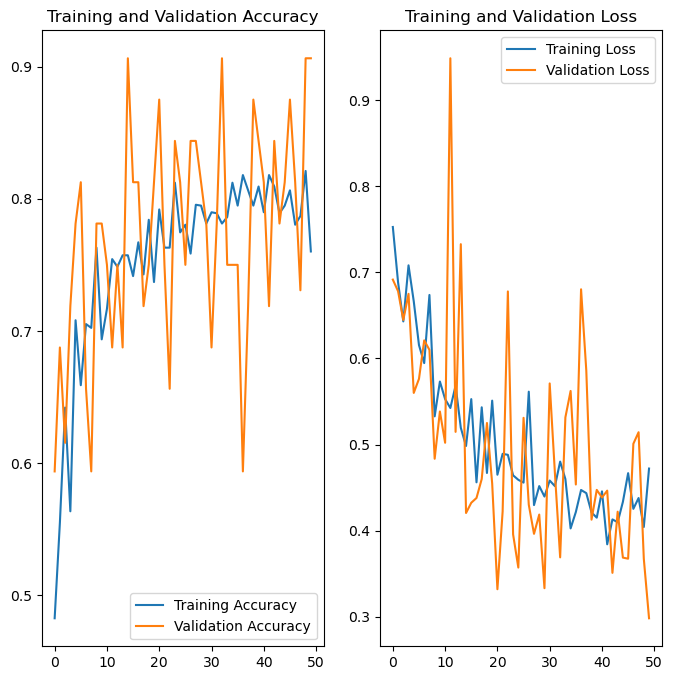

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1) #figura 1, 2 subgrades de gráfico, exibir plot na subgrade de gráfico 1 (gráfico esquerdo) 
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), validationAcc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2) #figura 1, 2 subgrades de gráfico, exibir plot na subgrade de gráfico 2 (gráfico direito)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), validationLoss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 438ms/step


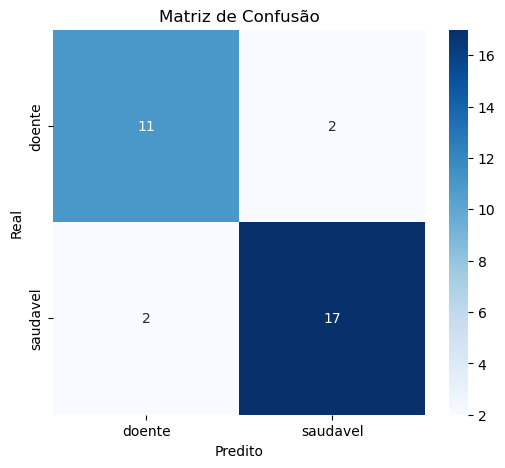

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_true = []
y_pred = []

for images, labels in testDs:
    preds = model.predict(images)  # Previsões do modelo
    preds = np.round(preds).flatten()  # Convertendo para valores binários (0 ou 1)
    
    y_true.extend(labels.numpy())  # Rótulos reais
    y_pred.extend(preds)  # Rótulos previstos

# Criando a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)

# Plotando a matriz de confusão
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classNames, yticklabels=classNames)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

first image to predict
first image's actual label:  saudavel
1/1 [==============================] - 0s 262ms/step
[0.49569148]


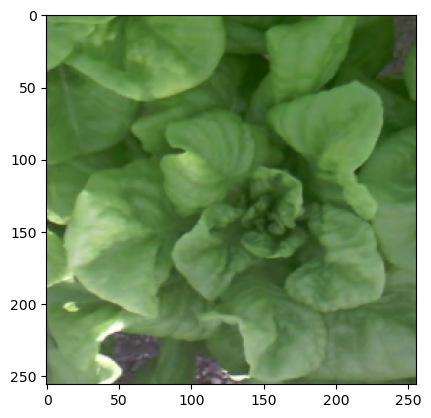

In [34]:
for images_batch, labels_batch in testDs.take(1):
    firstImage = images_batch[0].numpy().astype('uint8')
    firstLabel = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(firstImage)
    print("first image's actual label: ", classNames[firstLabel])

    batchPrediction = model.predict(images_batch)
    print(batchPrediction[0])

In [35]:
def predict(model, image):
    imageArray = tf.keras.preprocessing.image.img_to_array(image)
    imageArray = tf.expand_dims(imageArray, 0)  # Adiciona dimensão de batch

    predictions = model.predict(imageArray)[0, 0]  # Pegamos o valor escalar

    # Se o modelo usa sigmoid na saída
    predictedClass = classNames[1] if predictions >= 0.5 else classNames[0]
    confidence = round(100 * (predictions if predictions >= 0.5 else 1 - predictions), 2)

    return predictedClass, confidence


1/1 [==============================] - 0s 40ms/step


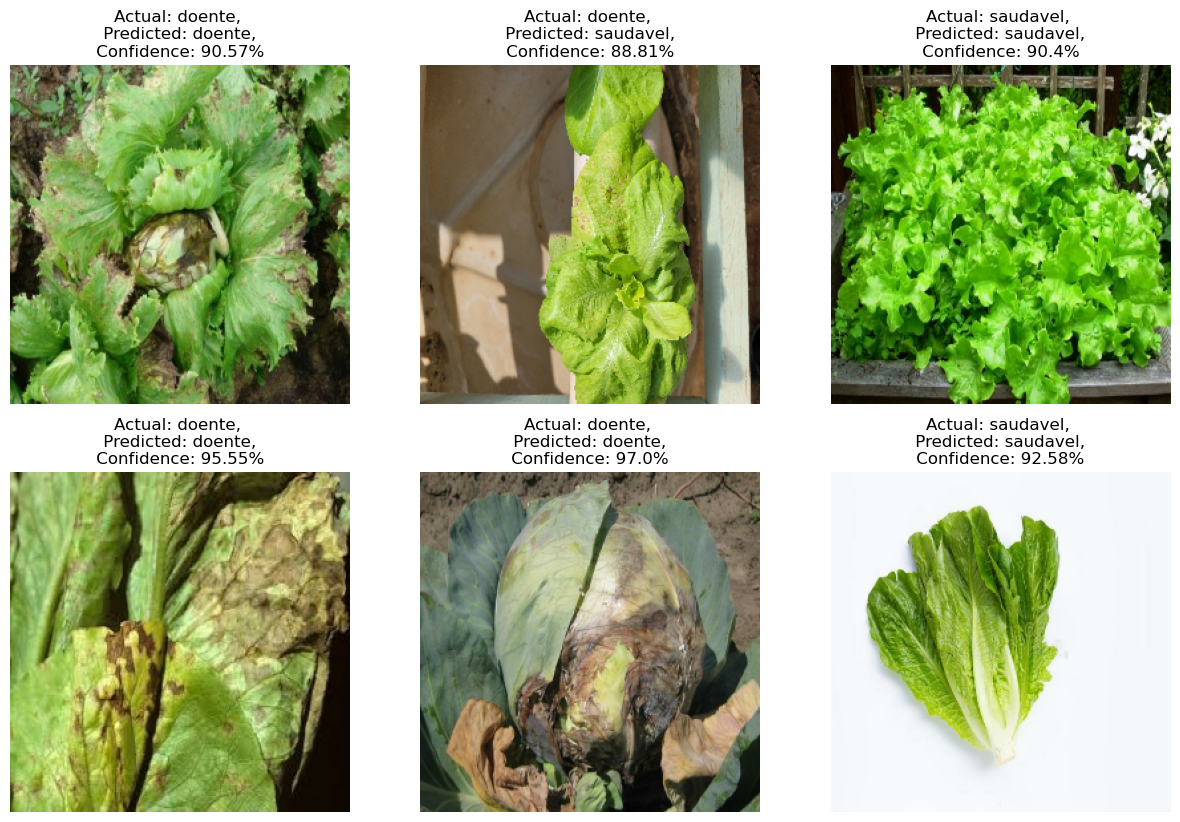

In [36]:
plt.figure(figsize = (15,15))
for images, labels in testDs.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predictedClass, confidence = predict(model, images[i].numpy())
        actualClass = classNames[labels[i]]

        plt.title(f"Actual: {actualClass}, \n Predicted: {predictedClass}, \n Confidence: {confidence}% ")
        
        plt.axis("off")
    

In [37]:
def predict_imagem_sistema_de_arquivo(model, image):
    imageArray = tf.keras.preprocessing.image.img_to_array(image)
    imageArray = tf.expand_dims(imageArray, 0)  # Adiciona dimensão de batch

    predictions = model.predict(imageArray)[0, 0]  # Pegamos o valor escalar

    # Se o modelo usa sigmoid na saída
    predictedClass = classNames[1] if predictions >= 0.5 else classNames[0]
    confidence = round(100 * (predictions if predictions >= 0.5 else 1 - predictions), 2)

    return predictedClass, confidence

    return predictions

In [47]:
from tensorflow.keras.preprocessing import image
import cv2
caminho_imagem = r"./../9º Período/Inteligencia Artificial e Aprendizado de Máquina/entrada/saudavel4.jpg"

In [48]:
def carregar_imagem(caminho):
    if not os.path.exists(caminho):
        raise FileNotFoundError(f"A imagem não foi encontrada: {caminho}")
    imagem = cv2.imread(caminho)
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)  # Converter para RGB
    # imagem = tf.convert_to_tensor(imagem, dtype=tf.float32)  # Converter para tensor
    # imagem = tf.expand_dims(imagem, axis=0)
    return imagem
# Função para pré-processar a imagem
def preprocessar_imagem(imagem, tamanho=(256, 256)):
    imagemPreprocessada = resizeAndRescale(imagem)
    return imagemPreprocessada

In [49]:
imagem = carregar_imagem(caminho_imagem)
imagemPreprocessada = preprocessar_imagem(imagem)
prediction = predict_imagem_sistema_de_arquivo(model, imagem)
print(f"Classe: {prediction} \n Confianca: ")

FileNotFoundError: A imagem não foi encontrada: ./../9º Período/Inteligencia Artificial e Aprendizado de Máquina/entrada/saudavel4.jpg

In [ ]:
#modelVersion=9
#model.save(f"..models/{modelVersion}.h5")

modelVersion = 1
path = f"models/{modelVersion}"

# Garantir que o diretório exista (sem o nome do arquivo)
directory = os.path.dirname(path)
os.makedirs(directory, exist_ok=True)

# Salvar o modelo
model.save(path)

